In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import re
import gc
import json

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)
from tqdm.notebook import tqdm
import scipy.stats as st
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

In [2]:
train = pd.read_csv('./train_dataset.csv', sep='\t')
print(train.shape)
train.head(3).append(train.tail(3))

(15016, 19)


,session_id,op_date,user_name,action,auth_type,ip,ip_location_type_keyword,ip_risk_level,location,client_type,browser_source,device_model,os_type,os_version,browser_type,browser_version,bus_system_code,op_target,risk_label
0,access:test_d:20180101111639:bBp1,2018/1/1 11:16,test_d,login,otp,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,chrome,chrome 90,coremail,management,0
1,access:test_d:20180101121524:OBSg,2018/1/1 12:15,test_d,login,qr,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,edge,edge 93,order-mgnt,sales,0
2,access:test_d:20180101151333:BpQN,2018/1/1 15:13,test_d,login,qr,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,chrome,chrome 90,order-mgnt,sales,0
15013,access:test_c:20191023152336:EUlA,2019/10/23 15:23,test_c,sso,NaN,27.10.135.254,代理IP,3级,"{""first_lvl"":""重庆"",""sec_lvl"":""重庆市"",""third_lvl"":...",web,desktop,macbook,macOS,macOS Big Sur 11,safari,safari 13,order-mgnt,sales,0
15014,access:test_c:20191023123533:MQfw,2019/10/23 12:35,test_c,login,pwd,27.10.135.254,代理IP,3级,"{""first_lvl"":""重庆"",""sec_lvl"":""重庆市"",""third_lvl"":...",web,desktop,macbook,macOS,macOS Big Sur 11,safari,safari 13,order-mgnt,sales,0
15015,access:test_c:20191023102054:QPZI,2019/10/23 10:20,test_c,sso,NaN,27.10.135.254,代理IP,3级,"{""first_lvl"":""重庆"",""sec_lvl"":""重庆市"",""third_lvl"":...",web,desktop,macbook,macOS,macOS Big Sur 11,safari,safari 13,order-mgnt,sales,0


<AxesSubplot:>

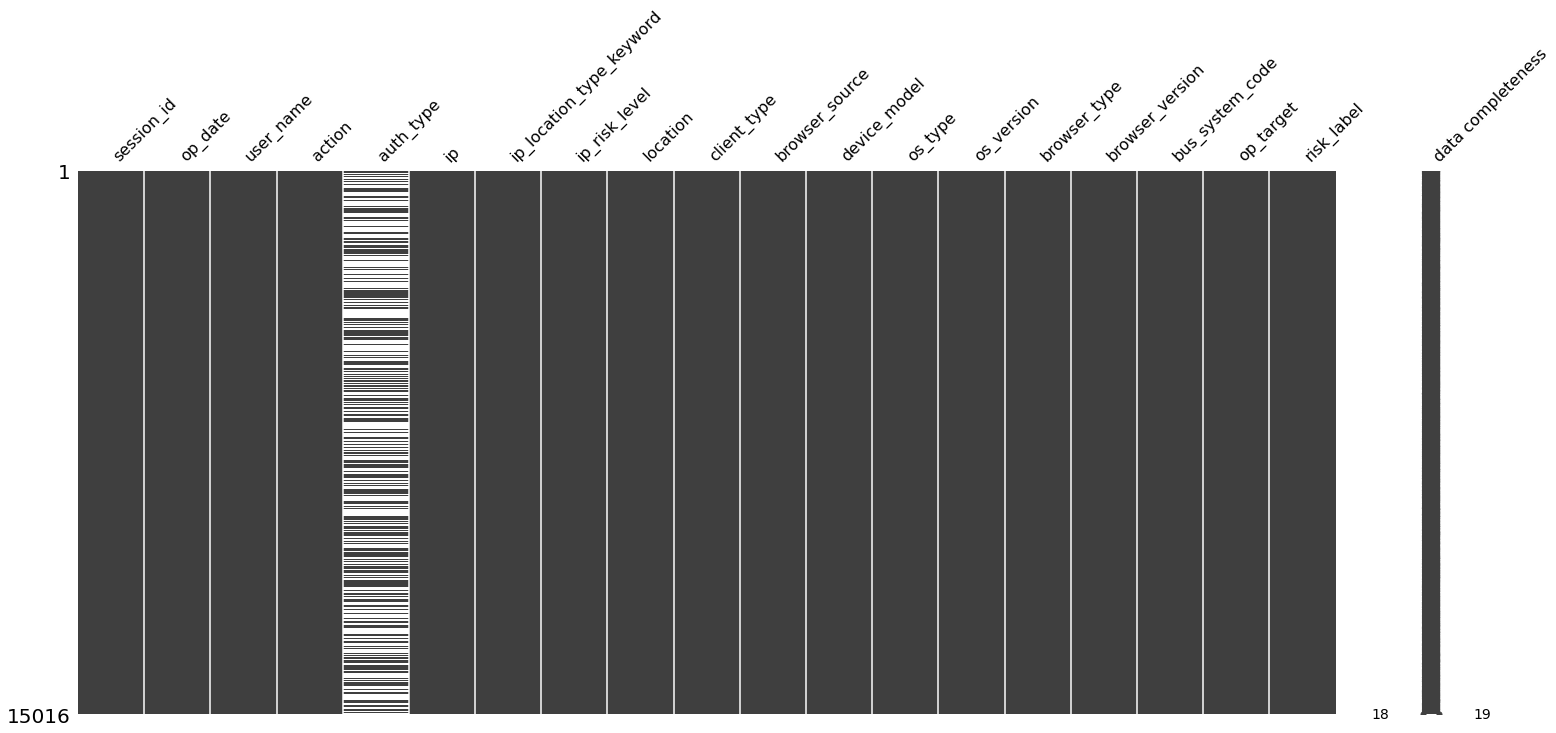

In [3]:
msno.matrix(train,labels=True)

In [4]:
test = pd.read_csv('./test_dataset.csv', sep='\t')
print(test.shape)
test.head(3).append(test.tail(3))

(10000, 18)


,session_id,op_date,user_name,action,auth_type,ip,ip_location_type_keyword,ip_risk_level,location,client_type,browser_source,device_model,os_type,os_version,browser_type,browser_version,bus_system_code,op_target
0,access:test_c:20191023212545:H2in,2019/10/23 21:25,test_c,sso,NaN,27.10.135.254,代理IP,3级,"{""first_lvl"":""重庆"",""sec_lvl"":""重庆市"",""third_lvl"":...",web,desktop,macbook,macOS,macOS Big Sur 11,safari,safari 13,order-mgnt,sales
1,access:test_c:20191023095634:ylxO,2019/10/23 9:56,test_c,sso,NaN,27.10.135.254,代理IP,3级,"{""first_lvl"":""重庆"",""sec_lvl"":""重庆市"",""third_lvl"":...",web,desktop,macbook,macOS,macOS Big Sur 11,safari,safari 13,order-mgnt,sales
2,access:test_c:20191023104233:tc9Y,2019/10/23 10:42,test_c,login,sms,27.10.135.254,代理IP,3级,"{""first_lvl"":""重庆"",""sec_lvl"":""重庆市"",""third_lvl"":...",web,desktop,macbook,macOS,macOS Big Sur 11,safari,safari 13,order-mgnt,sales
9997,access:test_a:20201231115831:TjRH,2020/12/31 11:58,test_a,sso,NaN,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,edge,edge 93,crm,sales
9998,access:test_a:20201231193033:8VtL,2020/12/31 19:30,test_a,login,otp,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,chrome,chrome 90,order-mgnt,sales
9999,access:test_a:20201231145833:3jgA,2020/12/31 14:58,test_a,login,otp,192.168.100.101,内网,1级,"{""first_lvl"":""成都分公司"",""sec_lvl"":""9楼"",""third_lvl...",web,desktop,think_pad_e460,windows,windows 10,edge,edge 93,order-mgnt,sales


<AxesSubplot:>

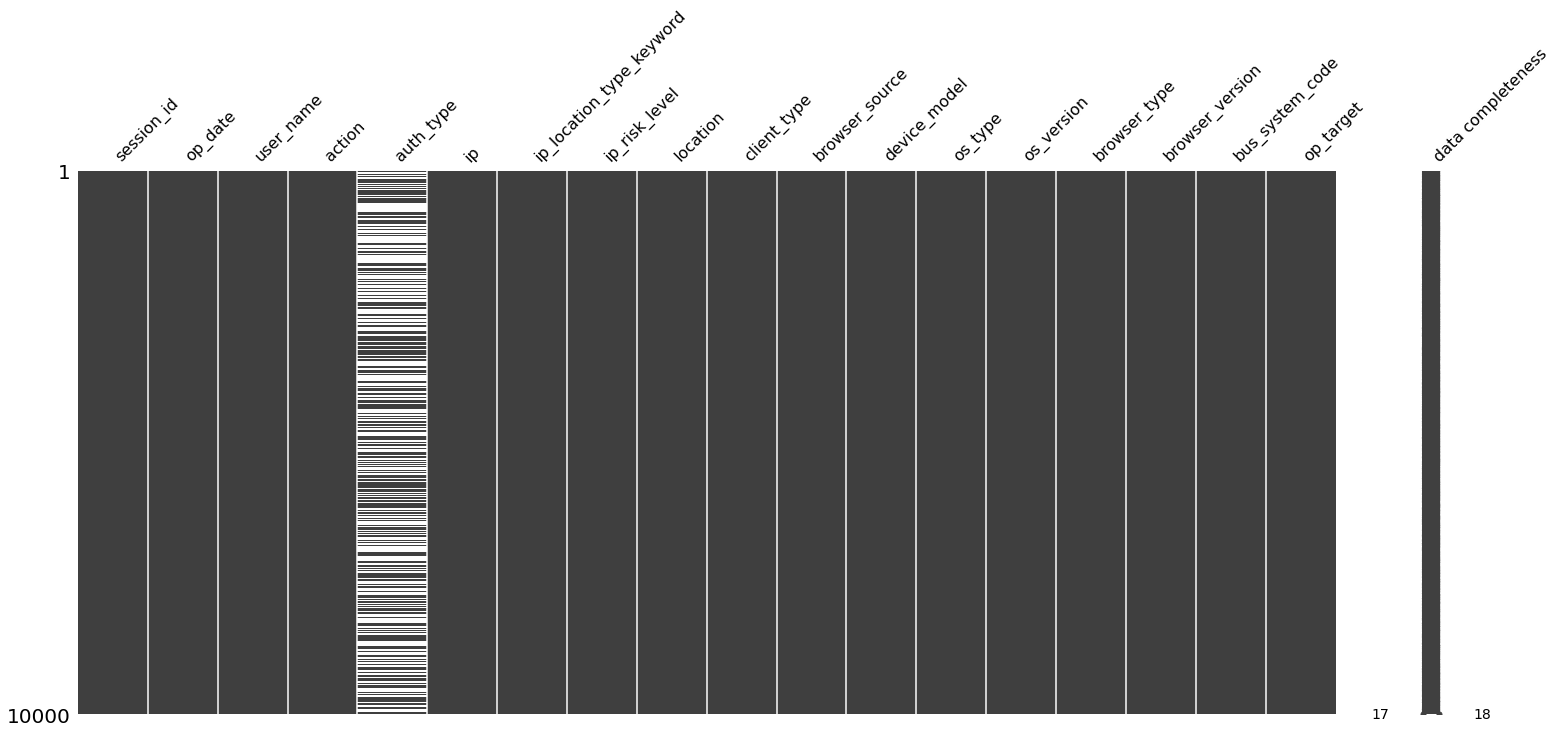

In [5]:
msno.matrix(test,labels=True)

In [6]:
train['risk_label'].value_counts(dropna=False)

0    12076
1     2940
Name: risk_label, dtype: int64

In [7]:
for f in ['user_name', 'action', 'auth_type', 'ip',
          'ip_location_type_keyword', 'ip_risk_level', 'location', 'client_type',
          'browser_source', 'device_model', 'os_type', 'os_version',
          'browser_type', 'browser_version', 'bus_system_code', 'op_target']:
    for v in train[f].unique():
        print(f, v, train[train[f] == v]['risk_label'].mean())
    print('='*50)

user_name test_d 0.190810465858328
user_name test_c 0.2004201680672269
user_name test_a 0.19375305026842363
user_name test_b 0.20043763676148796
user_name test_g 0.195578231292517
user_name test_e 0.1988888888888889
user_name test_f 0.19234116623150566
action login 0.1932896671567972
action sso 0.19827471798274718
auth_type otp 0.19203491543917076
auth_type qr 0.1888772298006296
auth_type nan nan
auth_type sms 0.19239013933547697
auth_type pwd 0.19989339019189764
ip 192.168.100.101 0.19682539682539682
ip 14.196.145.66 0.18600867678958785
ip 27.10.135.254 0.1939799331103679
ip 192.168.100.103 0.20709105560032232
ip 192.168.0.100 0.18235294117647058
ip_location_type_keyword 内网 0.19747828991315966
ip_location_type_keyword 家庭宽带 0.18600867678958785
ip_location_type_keyword 代理IP 0.1939799331103679
ip_risk_level 1级 0.19792024750773463
ip_risk_level 2级 0.18543956043956045
ip_risk_level 3级 0.1939799331103679
location {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl":"销售部"} 0.19682539682539682
loc

In [8]:
for f in ['user_name', 'action', 'auth_type', 'ip',
          'ip_location_type_keyword', 'ip_risk_level', 'location', 'client_type',
          'browser_source', 'device_model', 'os_type', 'os_version',
          'browser_type', 'browser_version', 'bus_system_code', 'op_target']:
    print(train.groupby(f).size())
    print('='*50)

user_name
test_a    6147
test_b    2285
test_c    2380
test_d    1567
test_e     900
test_f    1149
test_g     588
dtype: int64
action
login    7481
sso      7535
dtype: int64
auth_type
otp    1833
pwd    1876
qr     1906
sms    1866
dtype: int64
ip
14.196.145.66       1844
192.168.0.100        340
192.168.100.101    10395
192.168.100.103     1241
27.10.135.254       1196
dtype: int64
ip_location_type_keyword
代理IP     1196
内网      11976
家庭宽带     1844
dtype: int64
ip_risk_level
1级    11636
2级     2184
3级     1196
dtype: int64
location
{"first_lvl":"四川省","sec_lvl":"成都市","third_lvl":"武侯区"}       1844
{"first_lvl":"成都分公司","sec_lvl":"10楼","third_lvl":"会议室"}      340
{"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl":"会议室"}      1241
{"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl":"销售部"}     10395
{"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":"江北区"}        1196
dtype: int64
client_type
web    15016
dtype: int64
browser_source
desktop    15016
dtype: int64
device_model
macbook            2096
th

In [9]:
data = pd.concat([train, test])
print(data.shape)
data.head

(25016, 19)


<bound method NDFrame.head of                              session_id           op_date user_name action  \
0     access:test_d:20180101111639:bBp1    2018/1/1 11:16    test_d  login   
1     access:test_d:20180101121524:OBSg    2018/1/1 12:15    test_d  login   
2     access:test_d:20180101151333:BpQN    2018/1/1 15:13    test_d  login   
3     access:test_d:20180101124502:hYQm    2018/1/1 12:45    test_d    sso   
4     access:test_d:20180101202749:FkDK    2018/1/1 20:27    test_d    sso   
...                                 ...               ...       ...    ...   
9995  access:test_a:20201231155549:fSaL  2020/12/31 15:55    test_a    sso   
9996  access:test_a:20201231224950:uD7Y  2020/12/31 22:49    test_a    sso   
9997  access:test_a:20201231115831:TjRH  2020/12/31 11:58    test_a    sso   
9998  access:test_a:20201231193033:8VtL  2020/12/31 19:30    test_a  login   
9999  access:test_a:20201231145833:3jgA  2020/12/31 14:58    test_a  login   

     auth_type               ip i

In [10]:
data['location_first_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['first_lvl'])
data['location_sec_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['sec_lvl'])
data['location_third_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['third_lvl'])

data.drop(['client_type', 'browser_source'], axis=1, inplace=True)   #删除掉取值单一的字段
data['auth_type'].fillna('__NaN__', inplace=True)    #填充缺失值

In [11]:
for col in tqdm(['user_name', 'action', 'auth_type', 'ip', 
                 'ip_location_type_keyword', 'ip_risk_level', 'location', 'device_model',
                 'os_type', 'os_version', 'browser_type', 'browser_version',
                 'bus_system_code', 'op_target', 'location_first_lvl', 'location_sec_lvl', 
                 'location_third_lvl']):
    lbl = LabelEncoder()
    data[col] = lbl.fit_transform(data[col])   #对分类变量进行编码

  0%|          | 0/17 [00:00<?, ?it/s]

In [12]:
data['op_date'] = pd.to_datetime(data['op_date'])
data['op_ts'] = data["op_date"].values.astype(np.int64) // 10 ** 9    #将时间转化为时间戳

In [13]:
data = data.sort_values(by=['user_name', 'op_ts']).reset_index(drop=True)  #按照用户以及时间进行排序，方便后续进行分组求时间差
data['last_ts'] = data.groupby(['user_name'])['op_ts'].shift(1)   #滑动窗口得到同一用户下一个时间的值
data['ts_diff1'] = data['op_ts'] - data['last_ts']   #计算每个用户的时间差

In [14]:
for f in ['action','ip', 'location', 'device_model', 'os_version', 'browser_version','bus_system_code','op_target']:   #增加'action','bus_system_code','op_target'
    data[f'user_{f}_nunique'] = data.groupby(['user_name'])[f].transform('nunique') #统计每个用户对应不同的IP/地点/设备/操作系统/版本的数量

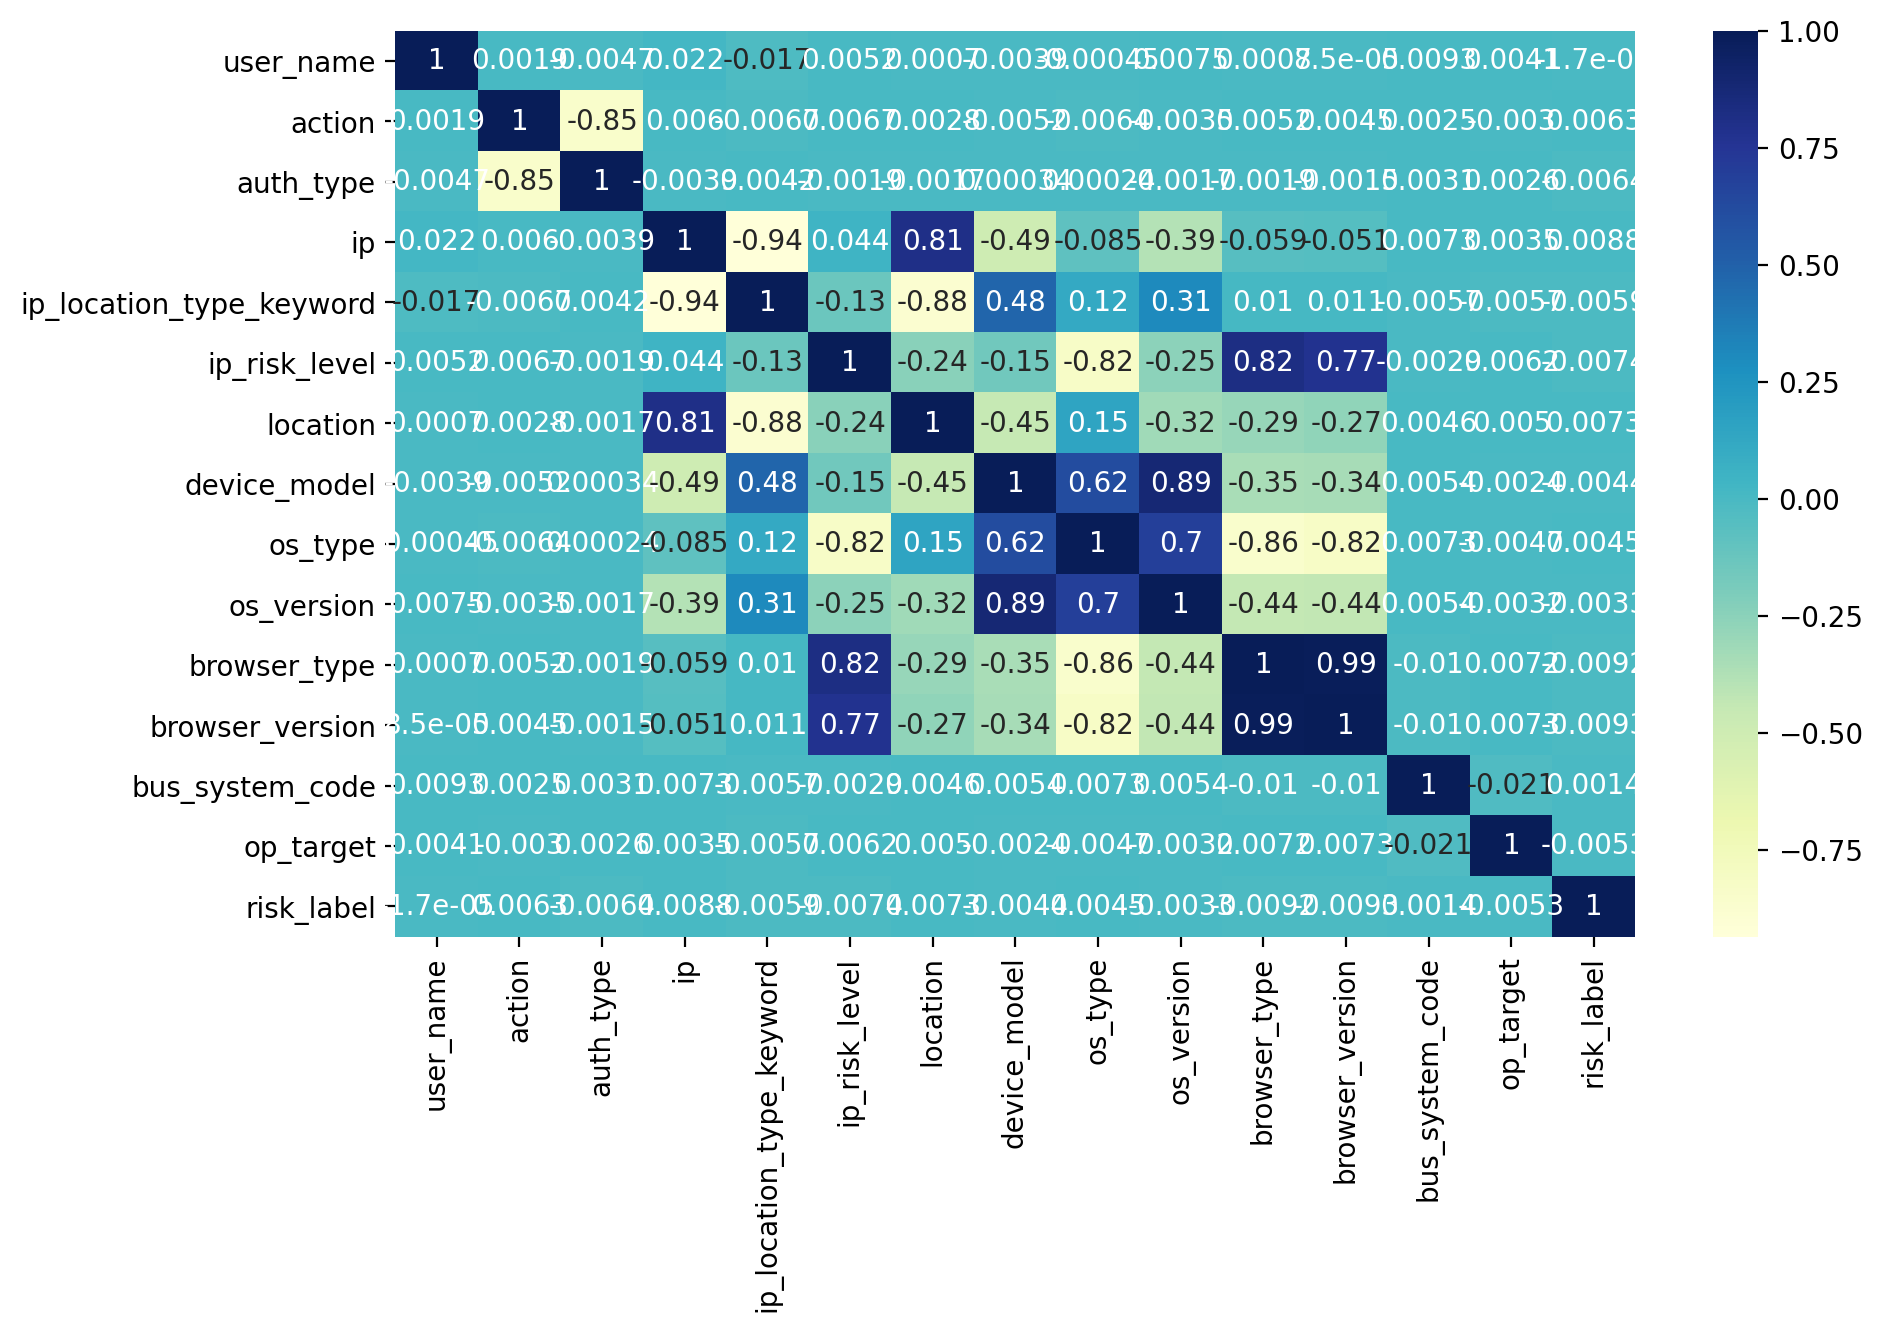

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(dpi=200, figsize=(10,6))
data_corr = data.iloc[:,2:17].corr()
ax = sns.heatmap(data_corr,annot=True, cmap="YlGnBu")

In [17]:
train[['action','auth_type']].value_counts()

action  auth_type
login   qr           1906
        pwd          1876
        sms          1866
        otp          1833
dtype: int64

In [14]:
# for method in ['mean', 'max', 'min', 'std']:
#     data[f'ts_diff1_{method}'] = data.groupby('user_name')['ts_diff1'].transform(method)

In [15]:
# for method in ['mean', 'max', 'min', 'std', 'sum', 'median','prod']:
#     for col in ['user_name', 'ip', 'location', 'device_model', 'os_version', 'browser_version']:
#         data[f'ts_diff1_{method}_' + str(col)] = data.groupby(col)['ts_diff1'].transform(method)

In [16]:
for col in ['user_name','action','ip', 'location', 'device_model', 'os_version', 'browser_version','bus_system_code','op_target']:
    for method in ['mean', 'max', 'min', 'std', 'sum', 'median','prod','count','mad','var']:
        data[f'ts_diff1_{method}_' + str(col)] = data.groupby(col)['ts_diff1'].transform(method)
    data['ts_diff1_cv_' + str(col)] = data['ts_diff1_max_' + str(col)]/data['ts_diff1_min_' + str(col)]
    data['ts_diff1_max-min_' + str(col)] = data['ts_diff1_max_' + str(col)] - data['ts_diff1_min_' + str(col)]
    data['ts_diff1_0.25_' + str(col)] = data.groupby(col)['ts_diff1'].transform(lambda x:x.quantile(.25))
    data['ts_diff1_0.75_' + str(col)] = data.groupby(col)['ts_diff1'].transform(lambda x:x.quantile(.75))
    data['ts_diff1_skew_' + str(col)] = data.groupby(col)['ts_diff1'].transform(lambda x:x.skew())
    data['ts_diff1_kurtosis_' + str(col)] = data.groupby(col)['ts_diff1'].transform(lambda x:x.kurtosis())

In [17]:
data.head().append(data.tail())

,session_id,op_date,user_name,action,auth_type,ip,ip_location_type_keyword,ip_risk_level,location,device_model,os_type,os_version,browser_type,browser_version,bus_system_code,op_target,risk_label,location_first_lvl,location_sec_lvl,location_third_lvl,op_ts,last_ts,ts_diff1,user_action_nunique,user_ip_nunique,user_location_nunique,user_device_model_nunique,user_os_version_nunique,user_browser_version_nunique,user_bus_system_code_nunique,user_op_target_nunique,ts_diff1_mean_user_name,ts_diff1_max_user_name,ts_diff1_min_user_name,ts_diff1_std_user_name,ts_diff1_sum_user_name,ts_diff1_median_user_name,ts_diff1_prod_user_name,ts_diff1_count_user_name,ts_diff1_mad_user_name,ts_diff1_var_user_name,ts_diff1_cv_user_name,ts_diff1_max-min_user_name,ts_diff1_0.25_user_name,ts_diff1_0.75_user_name,ts_diff1_skew_user_name,ts_diff1_kurtosis_user_name,ts_diff1_mean_action,ts_diff1_max_action,ts_diff1_min_action,ts_diff1_std_action,ts_diff1_sum_action,ts_diff1_median_action,ts_diff1_prod_action,ts_diff1_count_action,ts_diff1_mad_action,ts_diff1_var_action,ts_diff1_cv_action,ts_diff1_max-min_action,ts_diff1_0.25_action,ts_diff1_0.75_action,ts_diff1_skew_action,ts_diff1_kurtosis_action,ts_diff1_mean_ip,ts_diff1_max_ip,ts_diff1_min_ip,ts_diff1_std_ip,ts_diff1_sum_ip,ts_diff1_median_ip,ts_diff1_prod_ip,ts_diff1_count_ip,ts_diff1_mad_ip,ts_diff1_var_ip,ts_diff1_cv_ip,ts_diff1_max-min_ip,ts_diff1_0.25_ip,ts_diff1_0.75_ip,ts_diff1_skew_ip,ts_diff1_kurtosis_ip,ts_diff1_mean_location,ts_diff1_max_location,ts_diff1_min_location,ts_diff1_std_location,ts_diff1_sum_location,ts_diff1_median_location,ts_diff1_prod_location,ts_diff1_count_location,ts_diff1_mad_location,ts_diff1_var_location,ts_diff1_cv_location,ts_diff1_max-min_location,ts_diff1_0.25_location,ts_diff1_0.75_location,ts_diff1_skew_location,ts_diff1_kurtosis_location,ts_diff1_mean_device_model,ts_diff1_max_device_model,ts_diff1_min_device_model,ts_diff1_std_device_model,ts_diff1_sum_device_model,ts_diff1_median_device_model,ts_diff1_prod_device_model,ts_diff1_count_device_model,ts_diff1_mad_device_model,ts_diff1_var_device_model,ts_diff1_cv_device_model,ts_diff1_max-min_device_model,ts_diff1_0.25_device_model,ts_diff1_0.75_device_model,ts_diff1_skew_device_model,ts_diff1_kurtosis_device_model,ts_diff1_mean_os_version,ts_diff1_max_os_version,ts_diff1_min_os_version,ts_diff1_std_os_version,ts_diff1_sum_os_version,ts_diff1_median_os_version,ts_diff1_prod_os_version,ts_diff1_count_os_version,ts_diff1_mad_os_version,ts_diff1_var_os_version,ts_diff1_cv_os_version,ts_diff1_max-min_os_version,ts_diff1_0.25_os_version,ts_diff1_0.75_os_version,ts_diff1_skew_os_version,ts_diff1_kurtosis_os_version,ts_diff1_mean_browser_version,ts_diff1_max_browser_version,ts_diff1_min_browser_version,ts_diff1_std_browser_version,ts_diff1_sum_browser_version,ts_diff1_median_browser_version,ts_diff1_prod_browser_version,ts_diff1_count_browser_version,ts_diff1_mad_browser_version,ts_diff1_var_browser_version,ts_diff1_cv_browser_version,ts_diff1_max-min_browser_version,ts_diff1_0.25_browser_version,ts_diff1_0.75_browser_version,ts_diff1_skew_browser_version,ts_diff1_kurtosis_browser_version,ts_diff1_mean_bus_system_code,ts_diff1_max_bus_system_code,ts_diff1_min_bus_system_code,ts_diff1_std_bus_system_code,ts_diff1_sum_bus_system_code,ts_diff1_median_bus_system_code,ts_diff1_prod_bus_system_code,ts_diff1_count_bus_system_code,ts_diff1_mad_bus_system_code,ts_diff1_var_bus_system_code,ts_diff1_cv_bus_system_code,ts_diff1_max-min_bus_system_code,ts_diff1_0.25_bus_system_code,ts_diff1_0.75_bus_system_code,ts_diff1_skew_bus_system_code,ts_diff1_kurtosis_bus_system_code,ts_diff1_mean_op_target,ts_diff1_max_op_target,ts_diff1_min_op_target,ts_diff1_std_op_target,ts_diff1_sum_op_target,ts_diff1_median_op_target,ts_diff1_prod_op_target,ts_diff1_count_op_target,ts_diff1_mad_op_target,ts_diff1_var_op_target,ts_diff1_cv_op_target,ts_diff1_max-min_op_target,ts_diff1_0.25_op_target,ts_diff1_0.75_op_target,ts_diff1_skew_op_target,ts_diff1_ku

<AxesSubplot:>

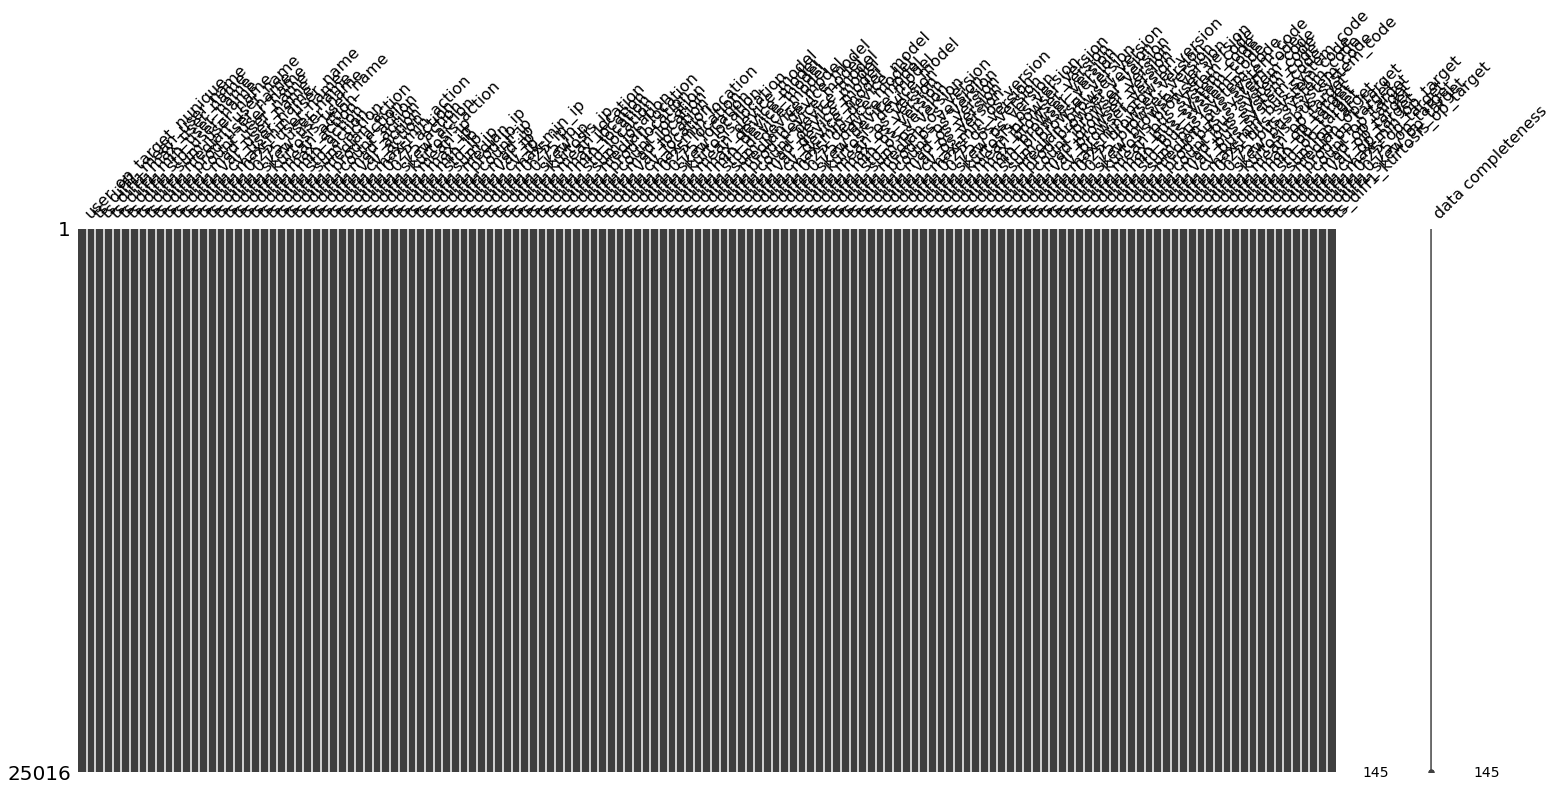

In [18]:
msno.matrix(data.iloc[:,30:],labels=True)

In [19]:
train = data[data['risk_label'].notna()]
test = data[data['risk_label'].isna()]

print(train.shape, test.shape)

(15016, 175) (10000, 175)


In [20]:
ycol = 'risk_label'
feature_names = list(
    filter(lambda x: x not in [ycol, 'session_id', 'op_date', 'last_ts'], train.columns))  #session_id可能有预测能力，因为黑产可能存在聚集


# model = lgb.LGBMClassifier(objective='binary',
#                            boosting_type='gbdt',
#                            tree_learner='serial',
#                            num_leaves=32,
#                            max_depth=6,
#                            learning_rate=0.1,
#                            n_estimators=10000,
#                            subsample=0.8,
#                            feature_fraction=0.6,
#                            reg_alpha=0.,
#                            reg_lambda=0.,
#                            random_state=1983,
#                            is_unbalance=True,
#                            metric='auc')    #建模

model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           tree_learner='serial',
                           num_leaves=2 ** 8,
                           max_depth=16,
                           learning_rate=0.2,
                           n_estimators=10000,
                           subsample=0.75,
                           feature_fraction=0.55,
                           reg_alpha=0.2,
                           reg_lambda=0.2,
                           random_state=1983,
                           is_unbalance=True,
                           # scale_pos_weight=130,
                           metric='auc')

oof = []
prediction = test[['session_id']]
prediction[ycol] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1983)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(train[feature_names], train[ycol])):
    X_train = train.iloc[trn_idx][feature_names]
    Y_train = train.iloc[trn_idx][ycol]

    X_val = train.iloc[val_idx][feature_names]
    Y_val = train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(fold_id+1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=500,
                          eval_metric='auc',
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(
        X_val, num_iteration=lgb_model.best_iteration_)
    df_oof = train.iloc[val_idx][['session_id', ycol]].copy()
    df_oof['pred'] = pred_val[:, 1]
    oof.append(df_oof)

    pred_test = lgb_model.predict_proba(
        test[feature_names], num_iteration=lgb_model.best_iteration_)
    prediction[ycol] += pred_test[:, 1] / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()
    
    
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg(
    'mean').sort_values(ascending=False).reset_index()
df_importance


Fold_1 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55

Fold_2 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55

Fold_3 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55

Fold_4 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55

Fold_5 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55


,column,importance
0,op_ts,645.800
1,ts_diff1,645.000
2,auth_type,165.600
3,ts_diff1_mean_user_name,131.000
4,bus_system_code,121.600
5,ts_diff1_max_bus_system_code,112.600
6,ts_diff1_mean_bus_system_code,91.600
7,ts_diff1_sum_user_name,91.400
8,ts_diff1_skew_user_name,81.200
9,browser_type,80.000


In [21]:
df_oof = pd.concat(oof)
print('roc_auc_score', roc_auc_score(df_oof[ycol], df_oof['pred']))

roc_auc_score 0.5153851007113677


In [22]:
prediction['id'] = range(len(prediction))
prediction['id'] = prediction['id'] + 1
prediction = prediction[['id', 'risk_label']].copy()
prediction.columns = ['id', 'ret']
prediction.head()

,id,ret
6147,1,0.289
6148,2,0.398
6149,3,0.335
6150,4,0.361
6151,5,0.317


In [23]:
# prediction['rank'] = prediction['risk_label'].rank()
# prediction['ret'] = 0
# prediction.loc[prediction['rank'] <= int(prediction.shape[0] * train['risk_label'].mean()), 'ret'] = 1

# prediction = prediction[['session_id', 'ret']].copy()
# prediction.columns = ['id', 'ret']
# prediction['id'] = range(len(prediction))
# prediction['id'] = prediction['id'] + 1
# prediction.head()

In [24]:
# print(prediction['ret'].value_counts())
# prediction.to_csv('bottomline.csv', index=False)

In [25]:
from time import time
timestamp = str(time())
prediction.to_csv(os.path.join('./result/',timestamp + '.csv'), index=False)